<a href="https://colab.research.google.com/github/Maternowsky/Maternowsky/blob/main/Combining_Different_Models_for_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ensemble Methods - Combine different classififiers into meta-classifier that has better generalization than perfomance than each individual classifier alone**

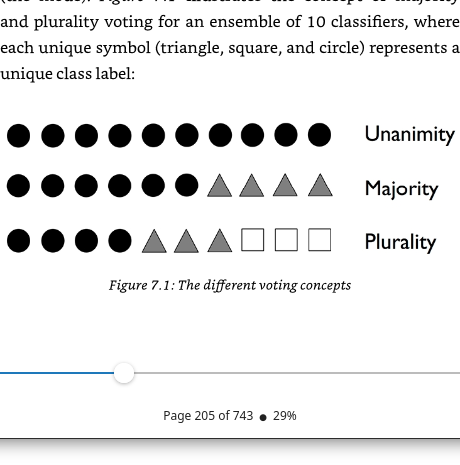

## **Probablility Mass Function**

In [1]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier/2.))
  probs = [comb(n_classifier, k) * error **k *
           (1-error)**(n_classifier - k)
           for k in range (k_start, n_classifier +1)]
  return sum(probs)

ensemble_error(n_classifier=11, error = 0.25)

0.03432750701904297

## **Compute ensemble error rates for a range of different base errors from 0.0 to 1.0**

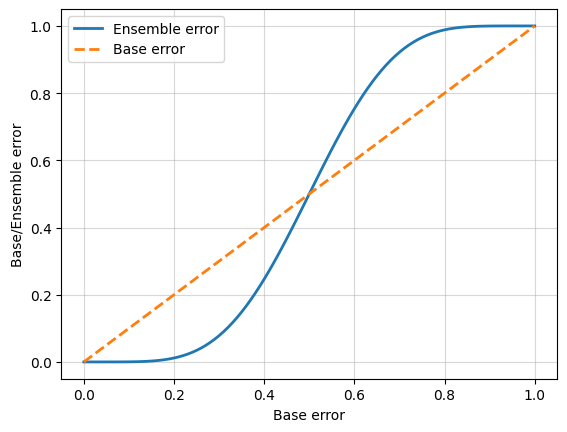

In [2]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier = 11, error=error)for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle = '--',
         label = 'Base error', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid(alpha =0.5)
plt.show()

### **Ensemble error is always better than eror of individual base classifier as long as the base classifiers perform better than random guessing (ε< 0.5)**

## **Weighted Majority Vote- use NumPys argmax and bincount. Bincount - count number of occurances of each label, argmax returns index position of the hightest count**

In [3]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6]))

1

### **Even though there is two 0's to one 1. The ones weight of 0.6 is higher than the combined weights of 0 which is 0.4**

## **Weighted majority vote based on class probablities using Numpys np.average and np.argmax**

In [4]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4,0.6]])
p = np.average(ex, axis=0, weights = [0.2, 0.2, 0.6])
np.argmax(p)

0

## **MajorityVoteClassifier in Python**

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

### **Majority vote on Iris Dataset, with 2 features**

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# Split Iris into 50 Training and 50 Test
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)

### **Train 3 classifiers using training dataset**

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty = 'l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator = clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring = 'roc_auc')
  print(f'ROC AUC: {scores.mean():.2f} ' f'(+/- {scores.std():.2f}) [{label}]')
  

10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


### **Combine for Majority Rule**

In [9]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator = clf,
                           X=X_train,
                           y = y_train,
                           cv = 10,
                           scoring = 'roc_auc')
  print(f'ROC AUC: {scores.mean():.2f} ' f'(+/- {scores.std():.2f})[{label}]')

ROC AUC: 0.92 (+/- 0.15)[Logistic regression]
ROC AUC: 0.87 (+/- 0.18)[Decision tree]
ROC AUC: 0.85 (+/- 0.13)[KNN]
ROC AUC: 0.98 (+/- 0.05)[Majority voting]


### **Evaluating and tuning the ensemble classifier**

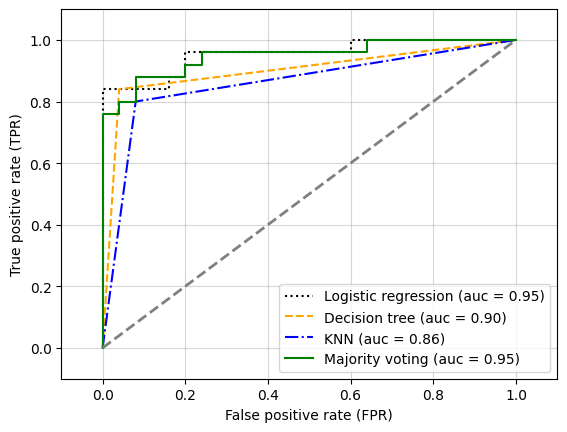

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors= ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
  #assuming the label of the positive class is 1
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y =tpr)
  plt.plot(fpr, tpr, color = clr,
           linestyle=ls, label = f'{label} (auc = {roc_auc:.2f})')
plt.legend(loc= 'lower right')
plt.plot([0, 1], [0,1], linestyle= '--', color = 'gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

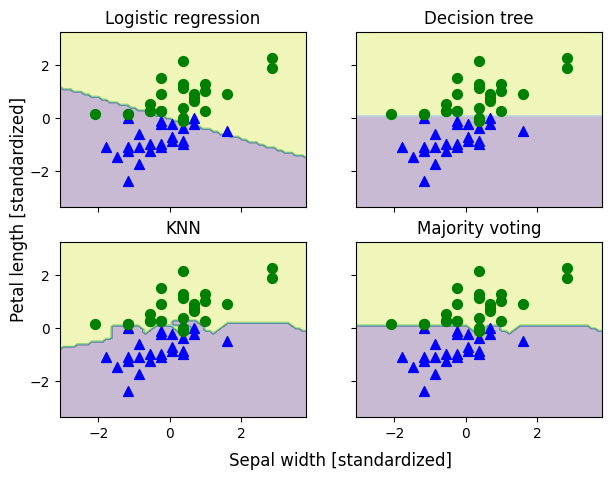

In [11]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 1].min() -1
y_max = X_train_std[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = 'col',
                        sharey = 'row', 
                        figsize = (7,5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
  clf.fit(X_train_std, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0,1],
                                c='blue', marker = '^',
                                s=50)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)
  axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5., s = 'Sepal width [standardized]',
         ha='center', va='center',
         fontsize=12)
plt.text(-12.5, 4.5,
         s = 'Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()


### **access individual parameters inside GridSearchCV**

In [12]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

### **Tuning Logistic regression and decision tree parameters after seeing what parameters we can access**

In [13]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1,2], 
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, 
                    param_grid = params,
                    cv = 10,
                    scoring = 'roc_auc')
grid.fit(X_train,y_train)
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  mean_score = grid.cv_results_['mean_test_score'][r]
  std_dev=grid.cv_results_['std_test_score'][r]
  params = grid.cv_results_['params'][r]
  print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [14]:
print(f'Best parameters: {grid.best_params_}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [15]:
print(f'ROC AUC : {grid.best_score_:.2f}')

ROC AUC : 0.98


## **Bagging - ensemble method, take random samples with replacement. example [1,2,3,4] -> c1 = [3,2,2,1] c2 = [1,4,3,3] c3 = [3,4,3,2]**

In [16]:
#using wine dataset

import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [17]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic Acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavenoids', 'Nonflavanoid phenols', 'Prothocynins',
                   'Color intensity', 'Hue', '0D280/0D315 of diluted wines',
                   'Proline']
#drop one class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', '0D280/0D315 of diluted wines']].values

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le= LabelEncoder()
y=le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y)


### **Use a decision tree classifier with ensemble of 500 decision treest on different bootstrap samples**

In [19]:
from sklearn.ensemble import BaggingClassifier
tree=DecisionTreeClassifier(criterion='entropy',
                            random_state=1,
                            max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

### **Calculate accuracy of prediciton**

In [20]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


In [21]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies ' f'{bag_train:.3f}/{bag_test:.3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging train/test accuracies 1.000/0.917


### **Compare Decision Regions**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


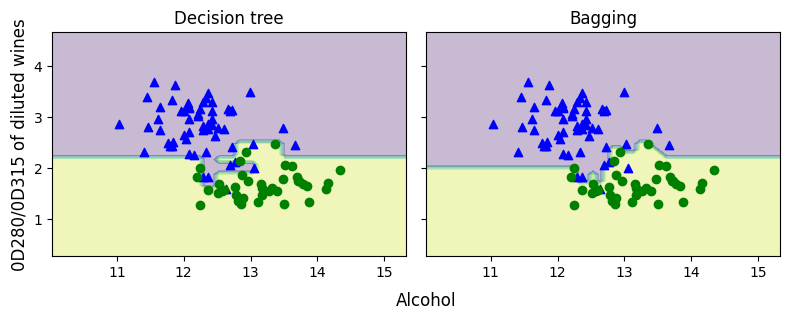

In [22]:
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() +1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr=plt.subplots(nrows=1, ncols=2,
                      sharex='col',
                      sharey='row',
                      figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree,bag],['Decision tree', 'Bagging']):
  clf.fit(X_train,y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue', marker = '^')
  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1], 
                     c = 'green', marker = 'o')
  axarr[idx].set_title(tt)

axarr[0].set_ylabel('0D280/0D315 of diluted wines', fontsize = 12)
plt.tight_layout()
plt.text(0,-0.2,
         s = 'Alcohol',
         ha='center',
         va='center',
         fontsize = 12,
         transform=axarr[1].transAxes)
plt.show()

# **How Adaptive boosting works**

## **Calculating weights, weighted error rate(epsilon)**

In [23]:
y = np.array([1,1,1,-1,-1,-1,1,1,1,-1])
yhat = np.array([1,1,1,-1,-1,-1, -1,-1 ,-1,-1])
correct = (y==yhat)  #boolean array of true and false
weights = np.full (10, 0.1)
print(weights)
epsilon = np.mean(~correct)  #number of incorrect '~'
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


## **calculate coefficient used to update weights**

In [24]:
alpha_j = 0.5 * np.log((1-epsilon)/ epsilon)
print(alpha_j)

0.42364893019360184


## **Update weights**

In [25]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 *1)
print('if correct:')
print(update_if_correct)
print('\n')

update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print('if incorrect:')
print(update_if_wrong_1)

if correct:
0.06546536707079771


if incorrect:
0.1527525231651947


In [26]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


## **use values to update the weights**

In [27]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


## **Normalize thew weights**

In [28]:
normalized_weights = weights/np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


### **AdaBoost with Scikit-Learn**

In [29]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              random_state=1,
                              max_depth = 1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate = 0.1,
                         random_state=1)
tree = tree.fit(X_train,y_train)
y_train_pred= tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies ' f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


### **Decision Tree stump seems to underfit training data**

In [30]:
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies ' f'{ada_train:.3f}/{ada_test:.3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


### **Checking Decision regions**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


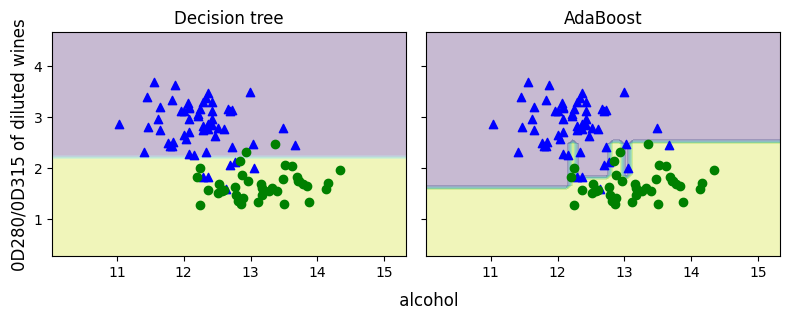

In [31]:
x_min = X_train[:, 0 ].min() - 1
x_max = X_train[:, 0 ].max() + 1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max,0.1))
f, axarr = plt.subplots(1,2,sharex='col',
                        sharey='row',
                        figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree, ada],
                        ['Decision tree', 'AdaBoost']):
  clf.fit(X_train,y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
  axarr[idx].scatter(X_train[y_train == 0, 0],
                     X_train[y_train == 0, 1],
                     c = 'blue',
                     marker = '^')
  axarr[idx].scatter(X_train[y_train == 1, 0],
                     X_train[y_train == 1, 1],
                     c = 'green',
                     marker = 'o')
  axarr[idx].set_title(tt)
  axarr[0].set_ylabel('0D280/0D315 of diluted wines', fontsize = 12)
plt.tight_layout()
plt.text(0, -0.2, s = ' alcohol',
         ha = 'center',
         va = 'center',
         fontsize =12,
         transform = axarr[1].transAxes)
plt.show()

# **Gradient Boosting - training an ensemble based on loss gradients**

## **XGBoost**

In [35]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01,
                          max_depth=4, random_state=1,
                          use_label_encoder=False)
gbm = model.fit(X_train,y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies ' f'{gbm_train:.3f}/{gbm_test:.3f}')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGboost train/test accuracies 0.968/0.917
